In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Building ARIMA Models
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Libraries for Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
%matplotlib inline

In [3]:
# load dataset
df_JFC = pd.read_csv('./datasets/JFC.csv', header=0, index_col=0)
df_JFC.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
06/15/2023,234.8,234.6,235.0,233.0,240.06K,0.09%
06/14/2023,234.6,235.0,235.0,233.0,138.21K,-0.17%
06/13/2023,235.0,235.0,235.6,233.6,281.51K,-0.25%
06/09/2023,235.6,235.0,236.0,234.4,325.88K,0.08%
06/08/2023,235.4,233.0,235.6,232.4,330.20K,1.03%


<class 'pandas.core.frame.DataFrame'>
Index: 982 entries, 06/15/2023 to 06/17/2019
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     982 non-null    float64
 1   Open      982 non-null    float64
 2   High      982 non-null    float64
 3   Low       982 non-null    float64
 4   Vol.      982 non-null    object 
 5   Change %  982 non-null    object 
dtypes: float64(4), object(2)
memory usage: 53.7+ KB


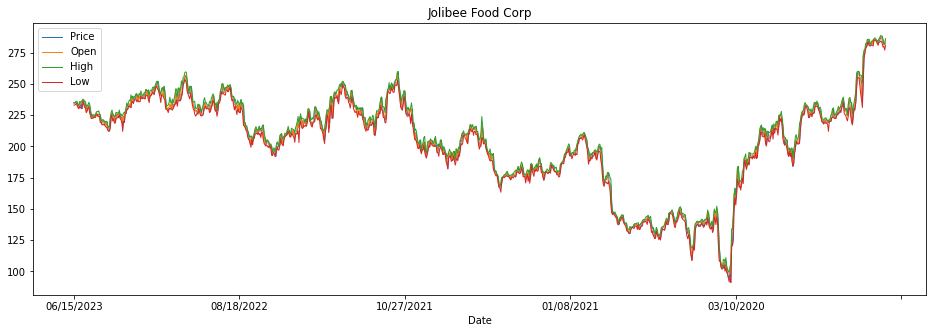

In [4]:
df_JFC.info()
df_JFC.plot(figsize=(16,5),lw=1, title="Jolibee Food Corp")
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

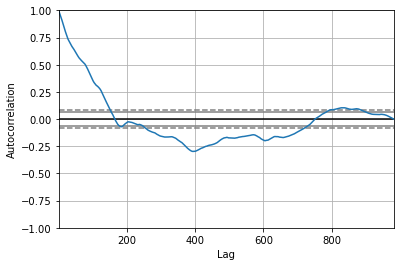

In [6]:
autocorrelation_plot(df_JFC[["Open","High","Low","Price"]])

### Choosing Close Columns for model predictions

<class 'pandas.core.series.Series'>
Index: 982 entries, 06/15/2023 to 06/17/2019
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
982 non-null    float64
dtypes: float64(1)
memory usage: 15.3+ KB


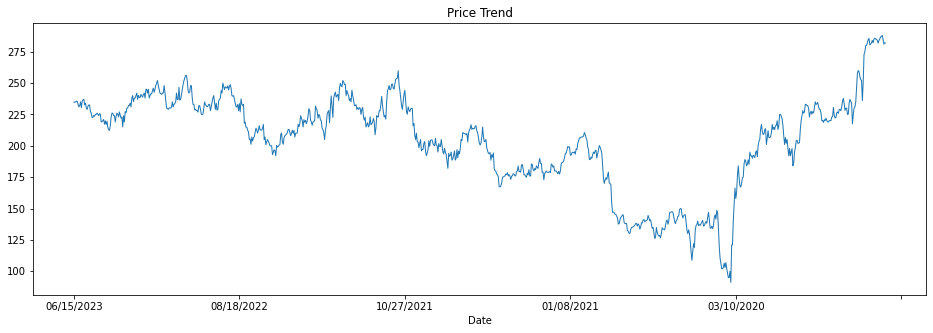

In [7]:
df_close = df_JFC["Price"]
df_close.info()
df_close.plot(figsize=(16,5),lw=1, title="Price Trend")
plt.show()

### Split data for train and test

In [70]:
# Split the data for train and test
df_train = df_close[20:].copy()
df_test = df_close[:20].copy()

In [9]:
# Creating function to display ACF anf PACF plot
def plot_correlation(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
    # ACF
    plot_acf(df, ax=ax1, lags=30)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
    # PACF
    plot_pacf(df, ax=ax2, lags=20)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

    # Lighten the borders
    ax1.spines['top'].set_alpha(.3); ax2.spines['top'].set_alpha(.3)
    ax1.spines['bottom'].set_alpha(.3); ax2.spines['bottom'].set_alpha(.3)
    ax1.spines['right'].set_alpha(.3); ax2.spines['right'].set_alpha(.3)
    ax1.spines['left'].set_alpha(.3); ax2.spines['left'].set_alpha(.3)

    ax1.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    plt.show()

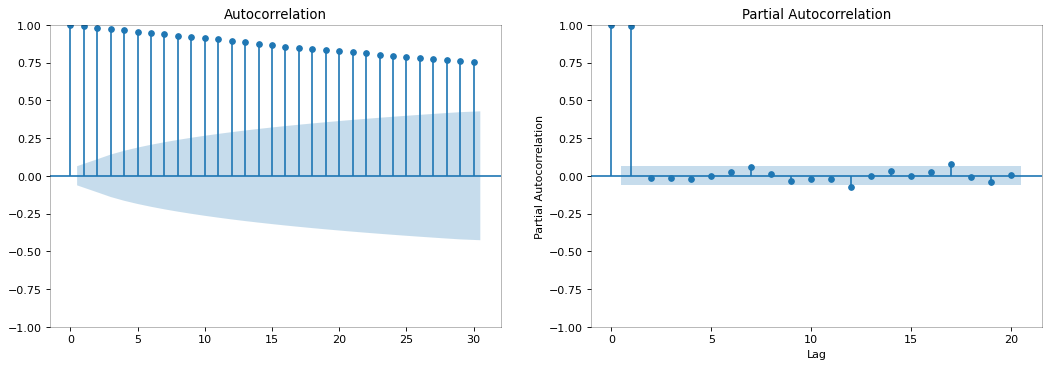

In [10]:
plot_correlation(df_train)

### Get p-value with ADF and KPSS test

In [11]:
#perform augmented Dickey-Fuller test to check if stationary
def ADF(df):
    result = adfuller(df)

    # Extract ADF Values
    print('Column Name: %s' % "Close Variable")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [12]:
ADF(df_train)

Column Name: Close Variable
ADF Statistic: -1.743837
p-value: 0.408679
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


In [14]:
# KPSS Test 
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [15]:
kpss_test(df_train.values)

Results of KPSS Test:
Test Statistic            2.026251
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Transform to stationary

p.value: -0.9999999999999716


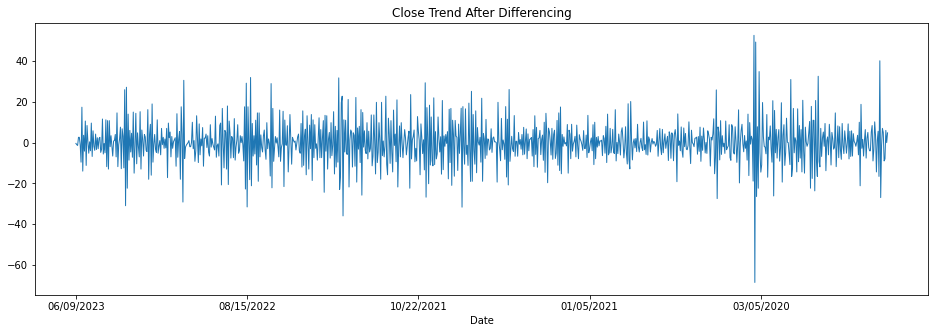

In [18]:
# Perform differencing
df_train_diff = df_train.diff().diff().diff().dropna()
df_train_diff.plot(figsize=(16,5), lw=1, title="Close Trend After Differencing")
print(f"p.value: {df_train_diff[1]}" )
plt.show()

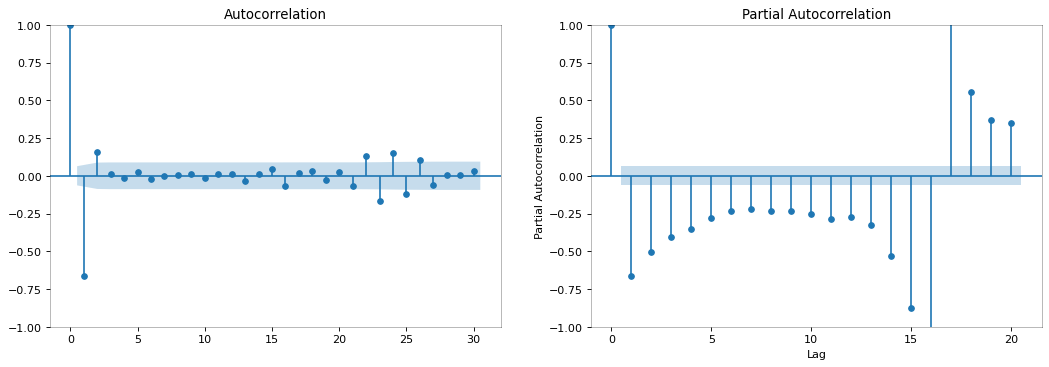

In [19]:
plot_correlation(df_train_diff)

## Determine model parameters p, q

In [20]:
# library that determine best parameters for ARIMA model
import pmdarima as pm
from pmdarima import auto_arima

In [55]:
model = auto_arima(df_train, start_p=0, start_q=0,
                          max_p=3, max_q=2,m=12,start_P=0,start_Q=0, 
                          max_P = 3, max_Q = 2,
                          seasonal=True,
                          d=3,D=3,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,3,0)[12]             : AIC=9502.608, Time=0.94 sec
 ARIMA(1,3,0)(1,3,0)[12]             : AIC=7713.442, Time=5.40 sec
 ARIMA(0,3,1)(0,3,1)[12]             : AIC=inf, Time=7.85 sec
 ARIMA(1,3,0)(0,3,0)[12]             : AIC=8864.043, Time=1.63 sec
 ARIMA(1,3,0)(2,3,0)[12]             : AIC=7625.008, Time=14.80 sec
 ARIMA(1,3,0)(3,3,0)[12]             : AIC=7588.169, Time=40.98 sec
 ARIMA(1,3,0)(3,3,1)[12]             : AIC=inf, Time=34.77 sec
 ARIMA(1,3,0)(2,3,1)[12]             : AIC=inf, Time=36.89 sec
 ARIMA(0,3,0)(3,3,0)[12]             : AIC=8122.904, Time=16.54 sec
 ARIMA(2,3,0)(3,3,0)[12]             : AIC=7321.770, Time=41.14 sec
 ARIMA(2,3,0)(2,3,0)[12]             : AIC=7349.081, Time=23.44 sec
 ARIMA(2,3,0)(3,3,1)[12]             : AIC=inf, Time=78.82 sec
 ARIMA(2,3,0)(2,3,1)[12]             : AIC=inf, Time=41.80 sec
 ARIMA(3,3,0)(3,3,0)[12]             : AIC=7175.684, Time=52.73 sec
 ARIMA(3,3,0)(2,3,0)[12]          

## Fit the ARIMA Model

In [71]:
model = ARIMA(df_train, order=(1,3,1))
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  962
Model:                 ARIMA(1, 3, 1)   Log Likelihood               -3001.004
Date:                Thu, 15 Jun 2023   AIC                           6008.009
Time:                        16:37:57   BIC                           6022.606
Sample:                             0   HQIC                          6013.568
                                - 962                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4873      0.022    -21.882      0.000      -0.531      -0.444
ma.L1         -1.0000      4.252     -0.235      0.814      -9.333       7.333
sigma2        30.3405    128.825      0.236      0.8

## Make time series prediction

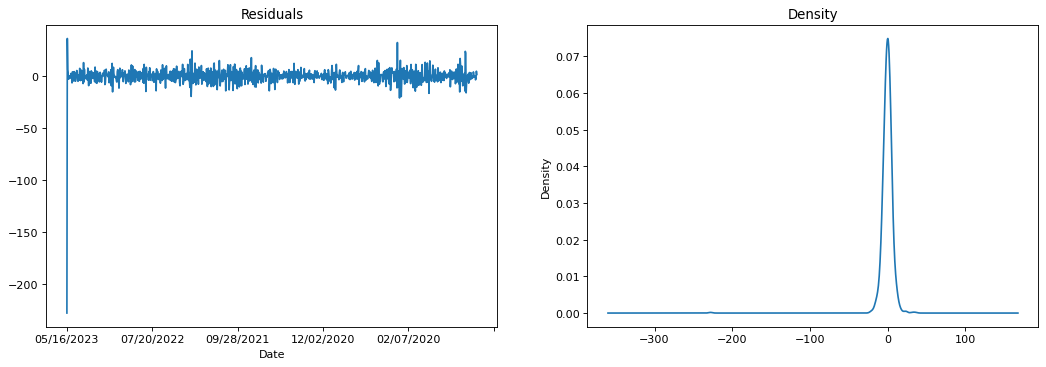

In [72]:
# Getting residuals pattern
# To make sure model capture adequate information from the data
residuals = model_fit.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(16,5), dpi=80)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

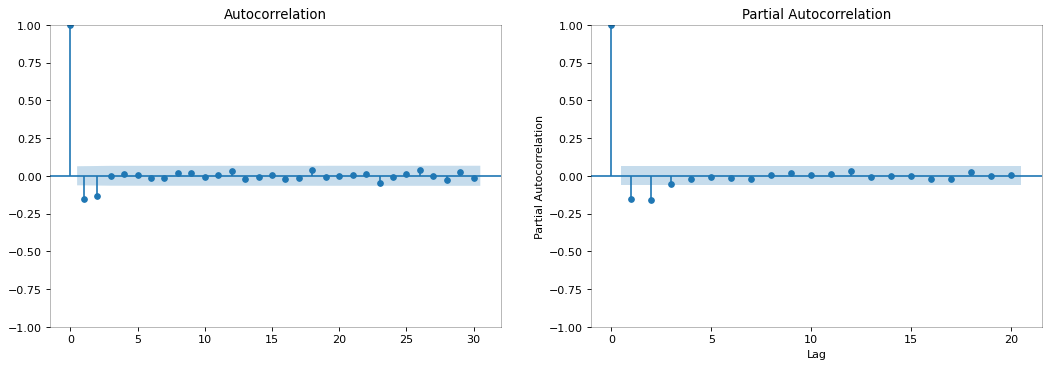

In [73]:
plot_correlation(residuals)

In [74]:
forecast = model_fit.forecast(len(df_test))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [75]:
forecast.index = df_test.index
new_df = pd.concat([forecast, df_test], axis=1)
new_df

,predicted_mean,Price
Date,,
06/15/2023,282.490598,234.8
06/14/2023,282.745384,234.6
06/13/2023,283.118357,235.0
06/09/2023,283.437005,235.6
06/08/2023,283.785397,235.4
06/07/2023,284.122564,233.0
06/06/2023,284.468472,231.0
06/05/2023,284.813390,232.0
06/02/2023,285.162060,235.0


<AxesSubplot:xlabel='Date'>

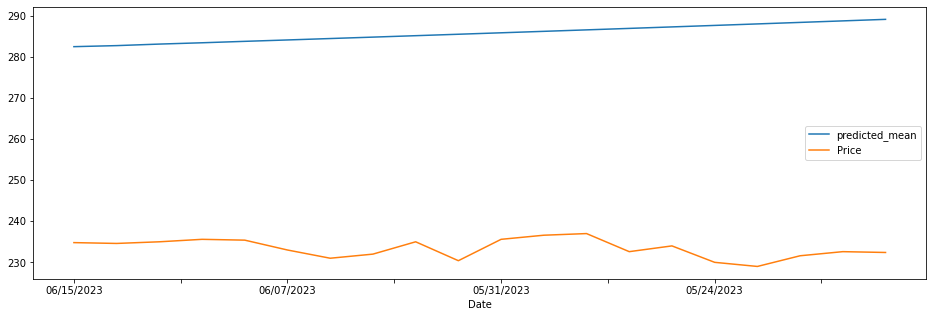

In [76]:
new_df.plot(figsize=(16,5))

## Fit the SARIMAX Model

In [56]:
train = df_close[20:].copy()
test = df_close[:20].copy()

In [57]:
final_model = SARIMAX(train,order=(3,3,0),seasonal_order=(3,3,0,12)) # Best model:  ARIMA(3,3,0)(3,3,0)[12]    
result = final_model.fit()
print(result.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.49194D+00    |proj g|=  4.12480D-02

At iterate    5    f=  3.98759D+00    |proj g|=  4.90661D-01

At iterate   10    f=  3.82960D+00    |proj g|=  1.16281D-01

At iterate   15    f=  3.81325D+00    |proj g|=  1.22494D-02

At iterate   20    f=  3.79566D+00    |proj g|=  4.42155D-02

At iterate   25    f=  3.78838D+00    |proj g|=  2.94281D-03

At iterate   30    f=  3.78832D+00    |proj g|=  9.14425D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

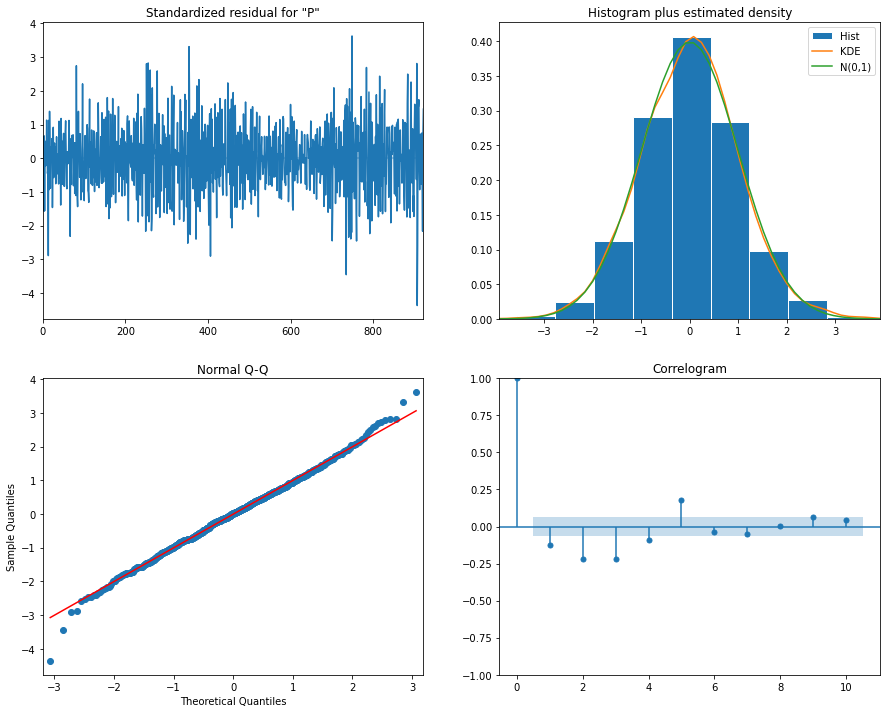

In [58]:
result.plot_diagnostics(figsize=(15, 12));

In [59]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# Best model:  ARIMA(3,3,0)(3,3,0)[12]
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(3,3,0)(3,3,0,12) Predictions')# Plot predictions against known values

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [60]:
predictions.index = test.index
joined_df = pd.concat([predictions, test], axis=1)
joined_df

,"SARIMA(3,3,0)(3,3,0,12) Predictions",Price
Date,,
06/15/2023,265.425874,234.8
06/14/2023,249.256281,234.6
06/13/2023,238.587374,235.0
06/09/2023,222.373084,235.6
06/08/2023,207.424868,235.4
06/07/2023,202.583811,233.0
06/06/2023,190.849002,231.0
06/05/2023,183.643504,232.0
06/02/2023,158.927440,235.0


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Production')]

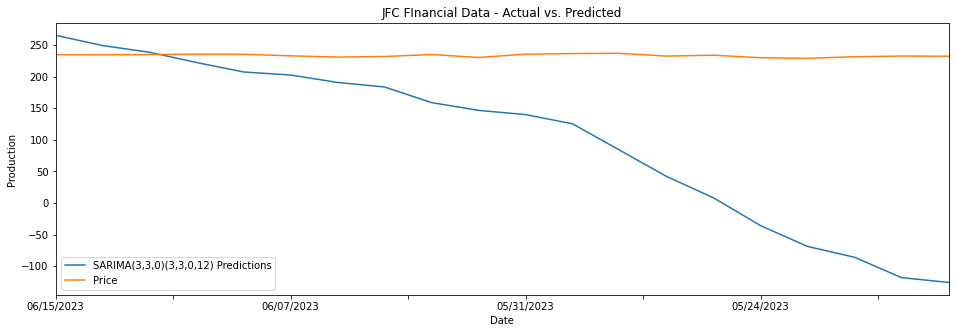

In [61]:
title = 'JFC FInancial Data - Actual vs. Predicted'
ylabel='Production'
xlabel='Date'
ax = joined_df.plot(legend=True, figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)